In [1]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sinkhorn_knopp import sinkhorn_knopp as skp
from sklearn.metrics import adjusted_rand_score
n_obs=1000 #number of observations per timepoint


In [2]:
adata = read_liver_data_2(n_obs=n_obs) #read data
adata = sort_data_crit(adata=copy.deepcopy(adata.copy()),crit='ZT',crit_list=['0','6','12','18']) #sort the data according to the timepoints
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_

View of AnnData object with n_obs × n_vars = 4000 × 14812
    obs: 'ZT', 'layer', 'batch'

In [4]:
#standard pre-processing
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)
orig_adata = copy.deepcopy(adata.copy())



Trying to set attribute `.var` of view, copying.


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


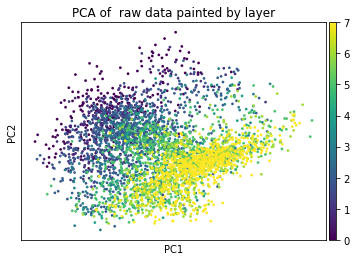

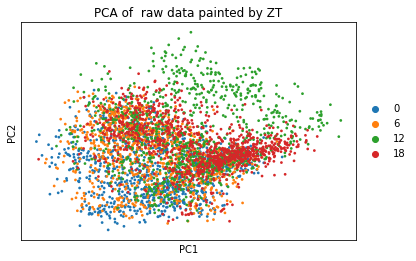

In [5]:
plots_liver(adata,title=" raw data")


7000
1
(4000, 7000)
(4000, 7000)
(4000, 3999)
Iteration number: 1


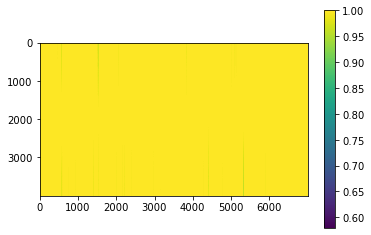

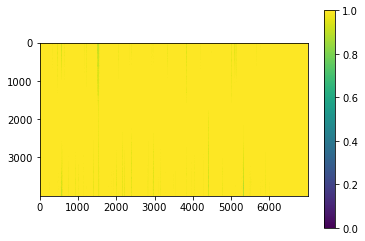

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


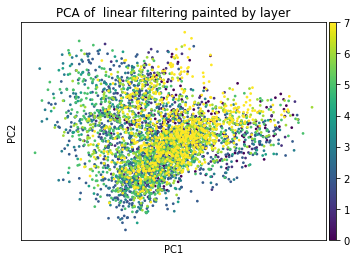

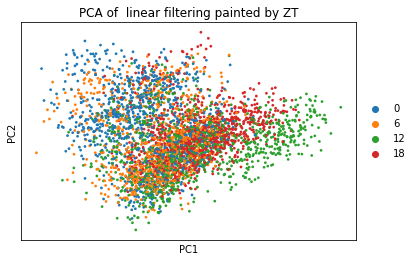

Norm change: 396.0119111778019


In [30]:
#linear filtering
linear_adata = copy.deepcopy(orig_adata.copy())
linear_adata = shuffle_adata(linear_adata)
linear_adata = sort_data_linear(linear_adata)
adata_linear_filtered = copy.deepcopy(linear_adata.copy())
F1 = filter_linear_full(adata_linear_filtered.X, regu=0.1 , regu_norm='L1' , iterNum=100 , method= 'numeric')
adata_linear_filtered.X = adata_linear_filtered.X * F1
plots_liver(adata_linear_filtered,title=" linear filtering")
print("Norm change: " +str(np.linalg.norm(linear_adata.X-adata_linear_filtered.X)))


starting filtering
25th Iteration    Loss :: 2208.325564516017 gradient :: 44.874266001092714
50th Iteration    Loss :: 1116.0590074774577 gradient :: 25.556527542200755
75th Iteration    Loss :: 798.4040023556754 gradient :: 11.602977764499215
100th Iteration    Loss :: 592.3962817649772 gradient :: 8.492818541292637
125th Iteration    Loss :: 514.813569523915 gradient :: 7.3196356589095375
150th Iteration    Loss :: 407.46661281398644 gradient :: 5.699721954220882
175th Iteration    Loss :: 360.00035794944796 gradient :: 4.985566329371307
200th Iteration    Loss :: 328.41339325793774 gradient :: 4.510630254652177
225th Iteration    Loss :: 287.99162709610107 gradient :: 3.9023989602198945
250th Iteration    Loss :: 262.4464438286557 gradient :: 3.5184605484609985
275th Iteration    Loss :: 243.75478542555362 gradient :: 3.2377927485278857
300th Iteration    Loss :: 229.53273671309285 gradient :: 3.024361427494444


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


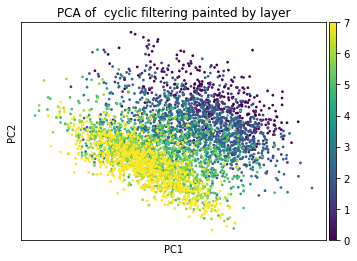

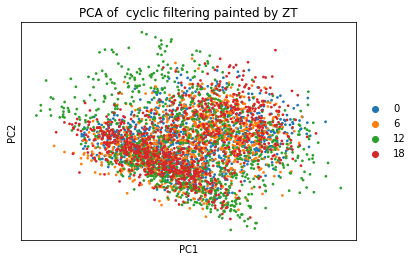

Norm change: 706.9954401594454


In [31]:
#cyclic filtering

adata_cyclic_filtered = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata_cyclic_filtered.X, regu=0, iterNum=300, verbosity=25)
adata_cyclic_filtered.X = adata_cyclic_filtered.X * F
plots_liver(adata_cyclic_filtered,title=" cyclic filtering")
print("Norm change: " +str(np.linalg.norm(orig_adata.X-adata_cyclic_filtered.X)))


25th Iteration    Loss :: 1892.8328256662487 gradient :: 21.75116318528676
Iteration number: 1 function value: 38745.13769403317
Iteration number: 26 function value: 267838.1465279377
Iteration number: 51 function value: 290811.6965206971
Iteration number: 76 function value: 298087.6195128911


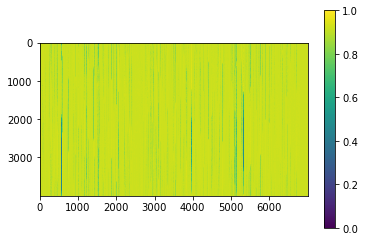

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


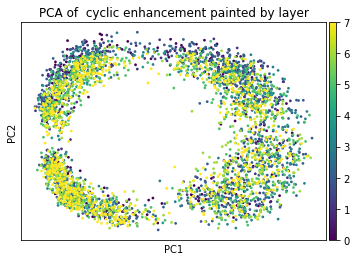

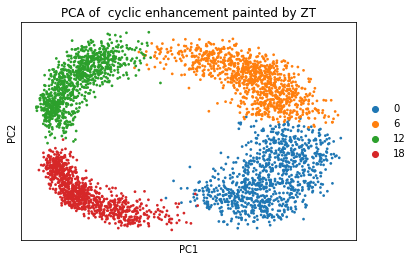

Norm change: 2110.772603370906


In [32]:
#cyclic enhancement
adata_cyclic_enhancment = copy.deepcopy(orig_adata.copy())
D = filter_non_cyclic_genes_line(adata_cyclic_enhancment.X, regu=1,iterNum=25)
adata_cyclic_enhancment.X = adata_cyclic_enhancment.X.dot(D)
F =enhancement_cyclic(adata_cyclic_enhancment.X, regu=0.01 ,iterNum=100)
adata_cyclic_enhancment.X = adata_cyclic_enhancment.X * F
plots_liver(adata_cyclic_enhancment,title=" cyclic enhancement")
print("Norm change: " +str(np.linalg.norm(orig_adata.X-adata_cyclic_enhancment.X)))


25th Iteration    Loss :: 1851.2150482077968 gradient :: 17.060901221435667
50th Iteration    Loss :: 1850.8318483247194 gradient :: 17.060432779802074


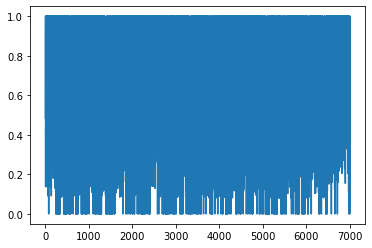

Iteration number: 1 function value: 43159.20240132769


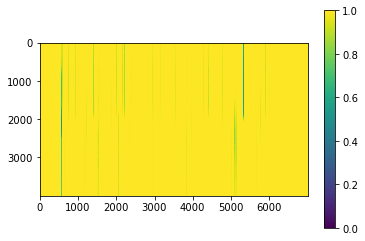

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


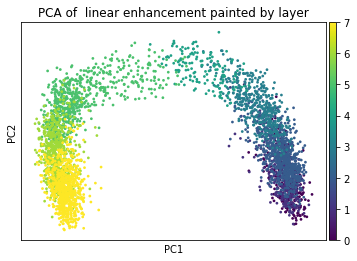

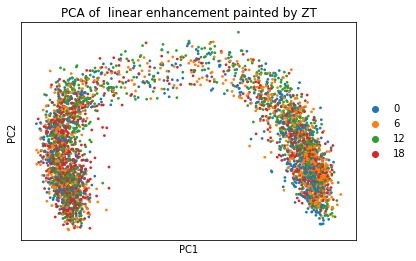

Norm change: 1364.0223049192136


In [13]:
#linear enhancement

adata_linear_enhanced = linear_adata.copy()

D = filter_linear_genes_line(adata_linear_enhanced.X,regu=1,method='numeric' , iterNum=50) #0.5
D1 = np.identity(D.shape[0])-D
plt.plot(range(7000),D.diagonal())
plt.show()

adata_linear_enhanced.X = adata_linear_enhanced.X.dot(D1)
F_en = enhancement_linear(adata_linear_enhanced.X, regu=-0.05, iterNum=10 , method='numeric') # -0.01
adata_linear_enhanced.X = adata_linear_enhanced.X * F_en
plots_liver(adata_linear_enhanced,title=" linear enhancement")
print("Norm change: " +str(np.linalg.norm(linear_adata.X-adata_linear_enhanced.X)))


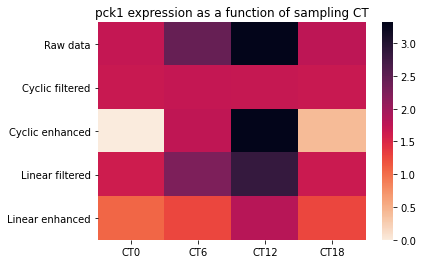

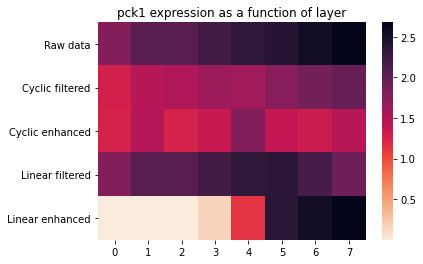

In [35]:
plt_mean_heatmap_gene_liver(adata,adata_cyclic_filtered,adata_cyclic_enhancment,adata_linear_filtered,adata_linear_enhanced,'pck1')


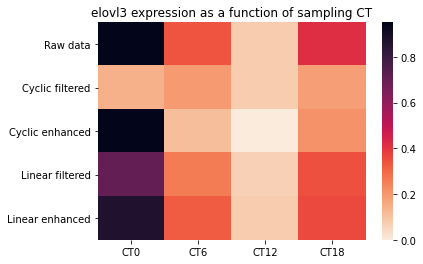

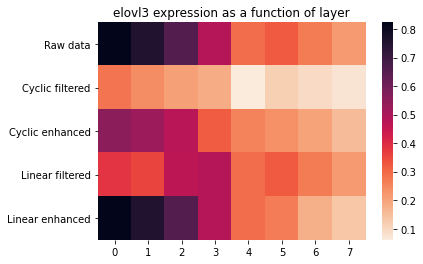

In [36]:
plt_mean_heatmap_gene_liver(adata,adata_cyclic_filtered,adata_cyclic_enhancment,adata_linear_filtered,adata_linear_enhanced,'elovl3')


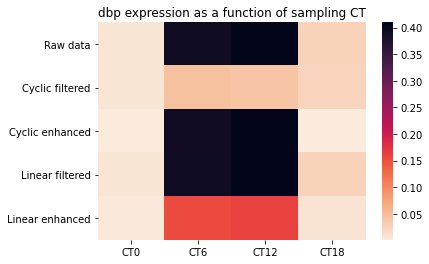

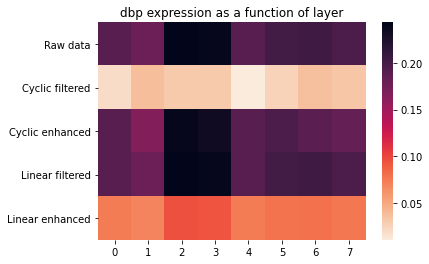

In [37]:
plt_mean_heatmap_gene_liver(adata,adata_cyclic_filtered,adata_cyclic_enhancment,adata_linear_filtered,adata_linear_enhanced,'dbp')


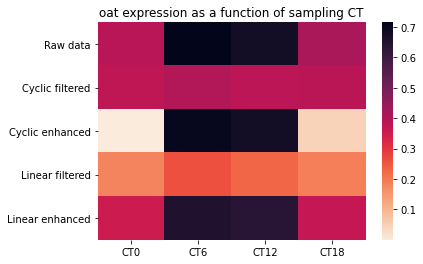

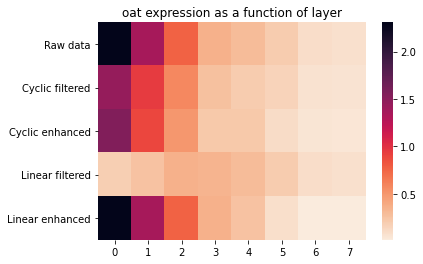

In [38]:
plt_mean_heatmap_gene_liver(adata,adata_cyclic_filtered,adata_cyclic_enhancment,adata_linear_filtered,adata_linear_enhanced,'oat')


In [33]:

kmeans = KMeans(n_clusters=8, random_state=0).fit(adata_linear_filtered.X)
print(adjusted_rand_score(kmeans.labels_ , adata_linear_filtered.obs['layer']))
alinear_kmeans_8 = (adjusted_rand_score(kmeans.labels_ , adata_linear_filtered.obs['layer']))


kmeans = KMeans(n_clusters=8, random_state=0).fit(adata_linear_enhanced.X)
print(adjusted_rand_score(kmeans.labels_ , adata_linear_enhanced.obs['layer']))
alinear_en_kmeans_8 = (adjusted_rand_score(kmeans.labels_ , adata_linear_enhanced.obs['layer']))


kmeans = KMeans(n_clusters=8, random_state=0).fit(orig_adata.X)
print(adjusted_rand_score(kmeans.labels_ , orig_adata.obs['layer']))
adata_kmeans_8 = (adjusted_rand_score(kmeans.labels_ , orig_adata.obs['layer']))


kmeans = KMeans(n_clusters=8, random_state=0).fit(adata_cyclic_filtered.X)
print(adjusted_rand_score(kmeans.labels_ , adata_cyclic_filtered.obs['layer']))
adata_cyclic_filtered_kmeans_8 = (adjusted_rand_score(kmeans.labels_ , adata_cyclic_filtered.obs['layer']))

kmeans = KMeans(n_clusters=8, random_state=0).fit(adata_cyclic_enhancment.X)
print(adjusted_rand_score(kmeans.labels_ , adata_cyclic_enhancment.obs['layer']))
adata_cyclic_enhancment_kmeans_8 = (adjusted_rand_score(kmeans.labels_ , adata_cyclic_enhancment.obs['layer']))



kmeans = KMeans(n_clusters=4, random_state=0).fit(adata_linear_filtered.X)
print(adjusted_rand_score(kmeans.labels_ , adata_linear_filtered.obs['ZT']))
alinear_kmeans = (adjusted_rand_score(kmeans.labels_ , adata_linear_filtered.obs['ZT']))


kmeans = KMeans(n_clusters=4, random_state=0).fit(adata_linear_enhanced.X)
print(adjusted_rand_score(kmeans.labels_ , adata_linear_enhanced.obs['ZT']))
alinear_en_kmeans = (adjusted_rand_score(kmeans.labels_ , adata_linear_enhanced.obs['ZT']))


kmeans = KMeans(n_clusters=4, random_state=0).fit(orig_adata.X)
print(adjusted_rand_score(kmeans.labels_ , orig_adata.obs['ZT']))
adata_kmeans = (adjusted_rand_score(kmeans.labels_ , orig_adata.obs['ZT']))


kmeans = KMeans(n_clusters=4, random_state=0).fit(adata_cyclic_filtered.X)
print(adjusted_rand_score(kmeans.labels_ , adata_cyclic_filtered.obs['ZT']))
adata_cyclic_filtered_kmeans = (adjusted_rand_score(kmeans.labels_ , adata_cyclic_filtered.obs['ZT']))

kmeans = KMeans(n_clusters=4, random_state=0).fit(adata_cyclic_enhancment.X)
print(adjusted_rand_score(kmeans.labels_ , adata_cyclic_enhancment.obs['ZT']))
adata_cyclic_enhancment_kmeans = (adjusted_rand_score(kmeans.labels_ , adata_cyclic_enhancment.obs['ZT']))


0.016843369002919165
0.5031543510663896
0.08254530103711419
0.1164655569425548
0.0035547094609300446
0.34880403676315613
0.006267263045797682
0.1096836451381461
0.012538475593780789
0.9600981996696618


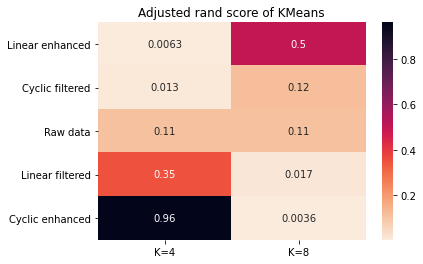

In [34]:

dat = np.array([[
                            alinear_en_kmeans,adata_cyclic_filtered_kmeans,adata_kmeans,alinear_kmeans,adata_cyclic_enhancment_kmeans
                  ],
                            [alinear_en_kmeans_8,adata_cyclic_filtered_kmeans_8,adata_kmeans,alinear_kmeans_8,adata_cyclic_enhancment_kmeans_8
                            ]])
dat = dat.T
df = pd.DataFrame(dat, index=
                ['Linear enhanced','Cyclic filtered','Raw data','Linear filtered','Cyclic enhanced'], columns=['K=4','K=8'])
ax = sns.heatmap(df,annot=True , cmap='rocket_r').set(title= "Adjusted rand score of KMeans")
plt.show()
